In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# (Optional) Use if you need to enforce packages. In Colab, torch & torchvision are usually preinstalled.
# !pip install -q torch torchvision matplotlib

# Check GPU availability and device name
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))


PyTorch version: 2.6.0+cu124
CUDA available: True
Device name: Tesla P100-PCIE-16GB


In [7]:
import os
import random
import numpy as np
import torch # core PyTorch
import torch.nn as nn # module for building NN layers
import torch.optim as optim # Optimizers
import torchvision # dataset & transform for vision
import torchvision.transforms as transforms # image tranform pipeline
from torch.utils.data import DataLoader # Dataloader batches dataset and handle shuffling
import matplotlib.pyplot as plt # for plot images/loss curves


# Device: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device", device)

using device cuda


In [8]:
# Reproducibility (best-effort)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 6

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.93MB/s]


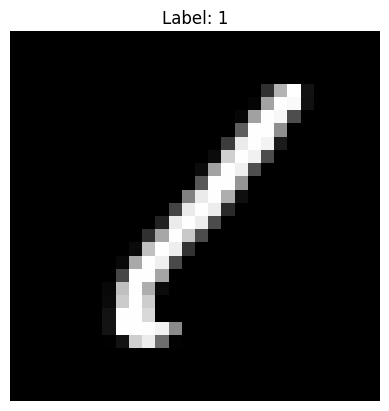

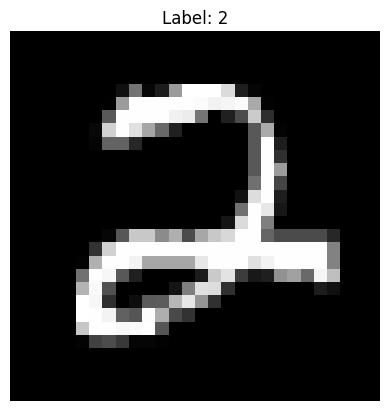

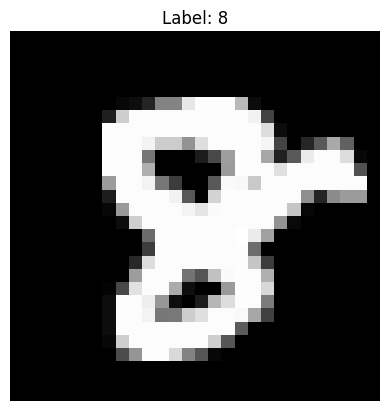

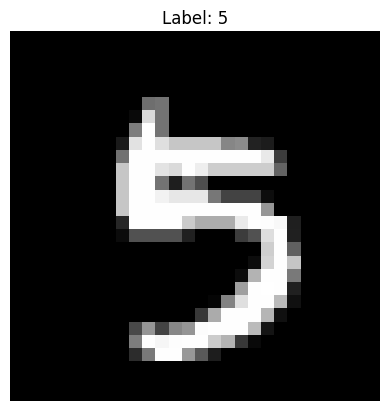

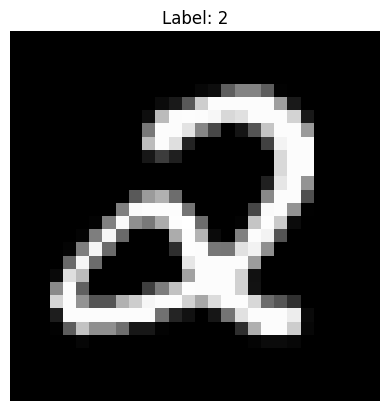

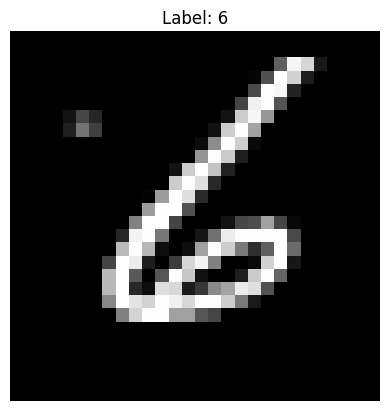

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mean & std for MNIST (single channel)
])

# Dataset download aur create karna
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Visualize a few images (unnormalize for display)
def imshow(img, label=None):
    img = img * 0.3081 + 0.1307 # unnormalize: x * std + mean
    np_img = img.squeeze().numpy() # shape 28x28
    plt.imshow(np_img, cmap='gray')
    if label is not None:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# show first 6 images
dataiter = iter(train_loader)
images, labels = next(dataiter)
for i in range(6):
    imshow(images[i], labels[i].item())

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # conv layer 1: in_channels=1(grayscale),out_channels=32, kernel=3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # conv layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # max pooling reduces HxW by factor 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # image size becomes half
        # fully connected layers 
        self.fc1 = nn.Linear(64*7*7, 128) # because 28 -> (pool)->14 -> (pool) -> 7
        self.fc2 = nn.Linear(128, 10) # 10 outputs (digits 0-9)
        # non-linearity and dropout
        self.relu = nn.ReLU() # activation function 
        self.dropout = nn.Dropout(0.25) # drop 25% neurons during training

    def forward(self, x):
        # x:[batch_size, 1, 28, 28]
        x = self.relu(self.conv1(x)) # -> [batch, 32, 28, 28]
        x = self.pool(x) # -> [batch, 32, 14, 14]
        x = self.relu(self.conv2(x)) # -> [batch, 64, 14, 14] 
        x = self.pool(x) # -> [batch, 64, 7, 7]  ✅ (yaha tumne 6 likh diya tha galti se)
        x = x.view(x.size(0), -1) # flatten -> [batch, 64*7*7]
        x = self.relu(self.fc1(x)) # -> [batch, 128]
        x = self.dropout(x)
        x = self.fc2(x) # -> [batch, 10] (logits)
        return x

# instantiate and move model to device 
model = SimpleCNN().to(device) 
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [11]:
criterion = nn.CrossEntropyLoss()          # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optional: scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [12]:
for epoch in range(1, num_epochs + 1):
    model.train()   # set model to training mode (enables dropout)
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # move to device
        images = images.to(device)
        labels = labels.to(device)

        # zero the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)            # logits shape: [batch, 10]
        loss = criterion(outputs, labels)  # scalar

        # backward pass + optimize
        loss.backward()
        optimizer.step()

        # accumulate stats
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = 100. * correct / total

    # Validation / test evaluation
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader.dataset)
    test_acc  = 100. * correct_test / total_test

    print(f"Epoch [{epoch}/{num_epochs}]  Train Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.2f}%  "
          f"Val Loss: {test_loss:.4f}  Val Acc: {test_acc:.2f}%")


Epoch [1/6]  Train Loss: 0.1635  Train Acc: 94.94%  Val Loss: 0.0455  Val Acc: 98.47%
Epoch [2/6]  Train Loss: 0.0539  Train Acc: 98.33%  Val Loss: 0.0313  Val Acc: 98.91%
Epoch [3/6]  Train Loss: 0.0391  Train Acc: 98.77%  Val Loss: 0.0279  Val Acc: 99.01%
Epoch [4/6]  Train Loss: 0.0312  Train Acc: 99.03%  Val Loss: 0.0276  Val Acc: 99.15%
Epoch [5/6]  Train Loss: 0.0254  Train Acc: 99.16%  Val Loss: 0.0237  Val Acc: 99.29%
Epoch [6/6]  Train Loss: 0.0203  Train Acc: 99.32%  Val Loss: 0.0276  Val Acc: 99.20%


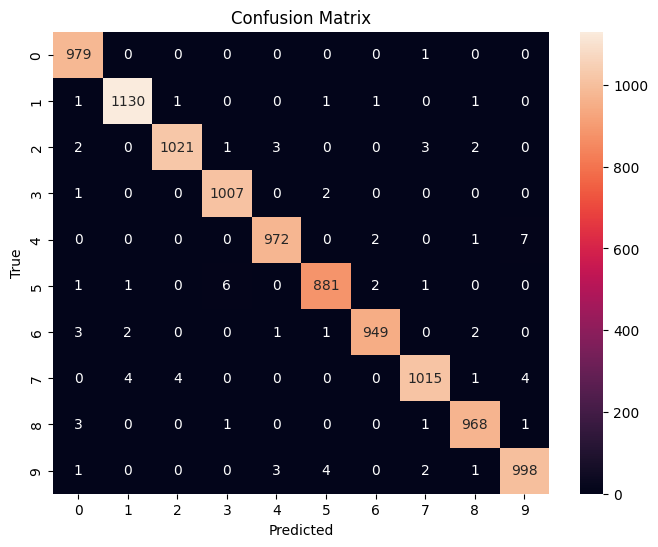

              precision    recall  f1-score   support

           0     0.9879    0.9990    0.9934       980
           1     0.9938    0.9956    0.9947      1135
           2     0.9951    0.9893    0.9922      1032
           3     0.9921    0.9970    0.9946      1010
           4     0.9928    0.9898    0.9913       982
           5     0.9910    0.9877    0.9893       892
           6     0.9948    0.9906    0.9927       958
           7     0.9922    0.9874    0.9898      1028
           8     0.9918    0.9938    0.9928       974
           9     0.9881    0.9891    0.9886      1009

    accuracy                         0.9920     10000
   macro avg     0.9920    0.9919    0.9919     10000
weighted avg     0.9920    0.9920    0.9920     10000



In [14]:
# Optional: install sklearn if not present
# !pip install -q scikit-learn

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Gather all predictions & labels
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, digits=4))
